In [1]:
import pystan 
import numpy as np
import matplotlib.pyplot as plt
import arviz as av
import pickle
from scipy.stats import entropy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Bayesian Active Learning by Disagreement (BALD)
This approach is based on "how much the model will improve if a particular labelled data is added to the training set". Here the Acquisition function is defined as reduction in Entropy of the Model's Posterior Distribution. This method is also called Bayesian Active Learning by Disagreement (BALD). This method again greedily selects data having maximum "reduction in Entropy of the Model's Posterior" value in every iteration.

\begin{equation}
    \begin{split}
 A(x_*) &=  \mathbb{H}[p(\theta | \mathcal{D}_O)] - \mathbb{E}_{p(y_* | x_*, \mathcal{D}_O )} \mathbb{H}[ p(y_* | \mathcal{D}_O \cup \{x_* , y_* \} )] \\
        &= \mathbb{I} [\theta ; y_* | x_*, \mathcal{D}_O]  \\
        &= \mathbb{H}[p(y_* | x_*, \mathcal{D}_O )] - \mathbb{E}_{p(\theta | \mathcal{D}_O)} \mathbb{H}[ p(y_* | x_*, \theta)] \label{eq:BALD}
    \end{split}
\end{equation}

where $x_*$ is the new data point, $y_*$ is the label for the new data point, $p(y_* | x_*, \mathcal{D}_O)$ is the Posterior Predictive Distribution, $\mathbb{H}[p(y_* | x_*, \mathcal{D}_O)]$ is the Entropy of Posterior Predictive Distribution, $\mathbb{I} [\theta ; y_* | x_*, \mathcal{D}_O]$ is the mutual information of two random variable $\theta$ and $y_*$ and $p(y_* | x_*, \theta)$ is the plug in predictive distribution. The first equality in the Eqn. 2 denotes the reduction in Entropy of posterior distribution once the $x_*$ is added to the training data. The second equality represents Mutual Information whose property can be utilized to switch $\theta$ and $y_*$. The first term in the third equality of Eqn. 2 is Entropy of Posterior Predictive Distribution (same as in Approach) whereas the second term (with negative sign) is Expected conditional Entropy. So essentially the input which produces high uncertainty is penalized and hence the name (BALD)


# Implementation: 
Models were trained using Logistic Regression. The Acquisition function in the above eqn. requires computation of posterior distribution of model parameters (for a Multi-class Logistic Regression). Since the Logistic Regression model has non conjugate Likelihood and Prior w.r.t. parameters, posterior distribution of model parameters can be computed either approximately (Laplace Approximation) or via Monte-Carlo Sampling methods. In this work, Probabilistic programming language "PyStan" was utilized to derive samples (through Monte Carlo Sampling) of posterior distribution of samples. These samples were utilized to compute the expectation in second term in R.H.S. of equation above. Computation of Posterior Predictive distribution (the first term in R.H.S. of the quation is similar to that MaxEnt

# Custom Function 

In [2]:
def PredictHardClass(model, D_pool):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        model: sklearn.linear_model e.g. sklearn.linear_model._logistic.LogisticRegression
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        T_hat: numpy.ndarray where each row is hard prediction of D_pool
    '''
    T_hat = model.predict(D_pool)
    return T_hat

def PredictSoftClass(model, D_pool):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        model: sklearn.linear_model e.g. sklearn.linear_model._logistic.LogisticRegression
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        T_proba: numpy.ndarray where each row is soft prediction of D_pool
    '''
    T_proba = model.predict_proba(D_pool)
    return T_proba

def getEntropy(T_proba):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        T_proba: numpy.ndarray where each row is soft prediction of D_pool
    Outputs:
        Ent: numpy.ndarray where each row is entropy of D_pool data
    '''
    N = T_proba.shape[0]
    Ent = np.zeros(N)
    for i in range(N):
        Ent[i] = entropy(T_proba[i], base = 2)
    return Ent

def Create_Fit_Save_Extract_StanModel(no_classes, D_Train, T_Train, filename):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Note: This function requires a Stan model to be coded and save separately
        Here, filename represents that file hence 'my_model.stan' should be available in the same folder
    Inputs:
        no_classes: int - no. of classes
        D_Train: ndarray - Training data - rows = no. of data point 
        T_Train: numpy.ndarray where each row is soft prediction of D_pool
        filename: name of the file in which stan model is saved
    Outputs:
        params: Dictionary - "beta" is key for all the samples of beta distribution
        fit: StanFit4Model - Stats of parameters of logistic reg model
        sm: pystan.model.StanModel - type of stan model defined 
    '''
    onehot_encoder = OneHotEncoder(sparse=False)
    T_Train = T_Train.reshape(len(T_Train), 1)
    T_Train = onehot_encoder.fit_transform(T_Train)
    T_Train = T_Train.astype(np.int)
    log_reg_data = {
             'N': D_Train.shape[0],
             'K': no_classes,
             'M': D_Train.shape[1],
             'X': D_Train,
             'Y': T_Train
            }
    
    sm = pystan.StanModel(file=filename)
    fit = sm.sampling(data=log_reg_data, iter=1000, chains=2)
    params = fit.extract()
    with open('model_fit.pkl','wb') as f:
        pickle.dump({'model':sm, 'fit':fit},f)
        
    with open('model_fit.pkl','rb') as f:
        data_dict = pickle.load(f)
        
    fit = data_dict['fit']
    sm = data_dict['model']
    return params, fit, sm

def Extract_4m_savedStanModel(filename):
    '''
    This function is used only when fitted stan model is saved as pickle
    Inputs:
        T_Train: numpy.ndarray (one hot vector) where each row is soft prediction of D_pool
    Outputs:
        params: Dictionary - "beta" is key for all the samples of beta distribution
        fit: StanFit4Model - Stats of parameters of logistic reg model
        sm: pystan.model.StanModel - type of stan model defined 
    '''
    with open(filename,'rb') as f:
        data_dict = pickle.load(f)
        
    fit = data_dict['fit']
    sm = data_dict['model']
    params = fit.extract()
    return params, fit, sm

def Predict_proba_4m_thetasamples(beta_samples, D_pool):
    '''
    Gives prredicted probability of data in pool set w.r.t. each beta samples
    Inputs:
        beta_samples: numpy.ndarray (No_samples x No_features x No_class) parameter of Logistic reg. model
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        pred_prob: numpy.ndarray (no_beta_samples x N x no_classes) soft prediction of D_pool for each beta sample
    '''
    no_beta_samples = beta_samples.shape[0]
    no_features = beta_samples.shape[1]
    no_classes = beta_samples.shape[2]
    N = D_pool.shape[0]
    
    pred_prob = np.zeros((no_beta_samples, N, no_classes))
    for i in range(no_beta_samples):
        pred_prob[i] = D_pool @ beta_samples[i]
        for j in range(N):
            for k in range(no_classes):
                pred_prob[i,j,k] = np.exp(pred_prob[i,j,k])
            norm = np.sum(pred_prob[i,j,:], dtype = np.float32)
            pred_prob[i,j,:] = pred_prob[i,j,:]/norm
    return pred_prob

def Compute_Expec_Entropy(beta_samples, D_pool):
    '''
    Compute expected entropy (2nd Term in equation of BALD)
    Inputs:
        beta_samples: numpy.ndarray (No_samples x No_features x No_class) parameter of Logistic reg. model
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        Ent: numpy.ndarray where each row is entropy of D_pool data
        Expec_Ent: numpy.ndarray where each row is Expected entropy (Exp wrt Posterior) of D_pool data
    '''
    pred_prob = Predict_proba_4m_thetasamples(beta_samples, D_pool)
    no_samples = pred_prob.shape[0]
    N = pred_prob.shape[1]
    
    Ent = np.zeros((no_samples,N))
    Expec_Ent = np.zeros(N)
    for i in range(no_samples):
        Ent[i,:] = getEntropy(pred_prob[i])
    Expec_Ent = np.mean(Ent, axis = 0)
    return Ent, Expec_Ent

def BALD_Acq_Fn(beta_samples, D_pool, model):
    '''
    Compute Acquisition function based on BALD Approach
    Inputs:
        beta_samples: numpy.ndarray (No_samples x No_features x No_class) parameter of Logistic reg. model
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
        model: sklearn.linear_model e.g. sklearn.linear_model._logistic.LogisticRegression
    Outputs:
        BALD_AF: 1-d numpy.ndarray value of BALD AF for each data in pool
    '''
    T_proba = PredictSoftClass(model, D_pool)
    Ent1 = getEntropy(T_proba)
    Ent_Samp, Ent2 = Compute_Expec_Entropy(beta_samples, D_pool)
    BALD_AF = Ent1 - Ent2
    return BALD_AF

def Find_argmax_AF(n, AF_pool):
    '''
    Using the entropy corresponding to each data point in D_pool, find 'n'
    data points with highest entropy values
    Inputs:
        n: (int) Number of data points to be selected
        AF_pool: numpy.ndarray where each row is entropy of D_pool data
    Outputs:
        arg_nmax: numpy.ndarray with index of 'n' data points with highest
                  entropy values
    '''
    arg_nmax = np.argpartition(AF_pool,-n)[-n:]
    return arg_nmax

def PicknDelete_4mPool(arg_nmax, D_pool, T_pool, AF):
    '''
    Function to pick data points from D_pool-T_pool using given indices,
    place them in D_select (used later to add to training set) and delete
    the selected data points from D_pool 
    Inputs:
        arg_nmax: numpy.ndarray with index of 'n' data points
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
        T_pool: numpy.ndarray where each row is a label corresponding to
                data in A.L. pool set
        AF: numpy.ndarray where each row is entropy of D_pool data
    Outputs:
        D_select: numpy.ndarray where each row is a data selected from the
                  A.L. pool set
        T_select: numpy.ndarray where each row is a label corresponding to
                  data selected from the A.L. pool set
        D_pool_upd: numpy.ndarray where each row is a data in the depleted
                    A.L. pool set
        T_pool_upd: numpy.ndarray where each row is a label corresponding to
                    data in the depleted A.L. pool set
    '''
    D_select = np.take(D_pool, arg_nmax, axis = 0)
    T_select = np.take(T_pool, arg_nmax, axis = 0)
    AF_select = np.take(AF, arg_nmax, axis = 0)
    
    
    D_pool_upd = np.delete(D_pool, arg_nmax, axis=0)
    T_pool_upd = np.delete(T_pool, arg_nmax, axis=0)
    AF_upd = np.delete(AF, arg_nmax, axis=0)
    return D_select, T_select, D_pool_upd, T_pool_upd

def Add_2Train(D_select, T_select, D_Train, T_Train):
    '''
    Adding selected data points to Train set D_Train-T_Train
    Inputs:
        D_select: numpy.ndarray where each row is a data selected from the
                  A.L. pool set
        T_select: numpy.ndarray where each row is a label corresponding to
                  data selected from the A.L. pool set
        D_Train: numpy.ndarray where each row is a data in the Train set
        T_Train: numpy.ndarray where each row is a label corresponding to
                 data in the Train set
    Outputs:
        D_Train_upd: numpy.ndarray where each row is a data in the updated
                     Train set
        T_Train_upd: numpy.ndarray where each row is a label corresponding to
                     data in the updated Train set
    '''
    D_Train_upd = np.vstack((D_Train, D_select))
    T_Train_upd = np.concatenate([T_Train,T_select])
    return D_Train_upd, T_Train_upd



# Classification Data Generation and Splitting

In [3]:
# Data Generation and Train, Test, AL Poolset creation
no_classes = 3
no_features = 5
no_samples = 1500
# Generate Data
X, y = make_classification(n_samples=no_samples, n_features=no_features, n_informative=3, n_redundant=2, n_classes=no_classes, random_state=1)

# Split Generated Data for initial Training and the Left over part
D_Train, D_left, T_Train, T_left = train_test_split(X, y, test_size=0.90, random_state=42)

# Split Left over Data for Testing and the Active Learning Poolset
D_test, D_pool, T_test, T_pool = train_test_split(D_left, T_left, test_size=0.75, random_state=40)



# Initial Training of the Logistic Regression Model

In [4]:
# Initial Training of data - Model => Logistic Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(D_Train, T_Train)


LogisticRegression(multi_class='multinomial')

# Initial Testing of the Logistic Regression Model

In [5]:
# Testing the initial LR model on TEST data
T_test_mod_proba = np.zeros((len(D_test),no_classes))
T_test_mod = np.zeros(len(D_test))
for i in range(len(D_test)):
    T_test_mod_proba = model.predict_proba(D_test)
    T_test_mod= model.predict(D_test)


acc = []
acc.append(accuracy_score(T_test, T_test_mod))
cm = []
cm.append(confusion_matrix(T_test, T_test_mod))

# Main Program: Overall Active Learning Process implementation

In [6]:
# Overall Active Learning Process implementation. This includes:
# 1. Computation of posterior distr. of Parameters using Stan (MCMC Method)
# 2. Computation of BALD Acquisition Function (BALD_AF)
# 3. Selection of "no_select" Data from Pool having max value of BALD_AF
# 4. Deletion of selected data from pool and inclusion in Training Data
# 5. Repeat until "AL_bound" is exhausted
AL_bound = 50
no_select = 1
select_count = []
i = 0
while i <= AL_bound:
    print(i)
    params, fit, sm = Create_Fit_Save_Extract_StanModel(no_classes, D_Train, T_Train,'my_model.stan')
    BALD_AF = BALD_Acq_Fn(params['beta'], D_pool, model)
    
    print(BALD_AF.shape)
    arg_nmax = Find_argmax_AF(no_select, BALD_AF)
    print(arg_nmax)
    D_select, T_select, D_pool, T_pool = PicknDelete_4mPool(arg_nmax, D_pool, T_pool, BALD_AF)
    D_Train, T_Train = Add_2Train(D_select, T_select, D_Train, T_Train)
    model.fit(D_Train, T_Train)
        
    T_test_mod_proba = PredictSoftClass(model, D_test)
    T_test_mod= PredictHardClass(model, D_test)
        
    acc.append(accuracy_score(T_test, T_test_mod))
    cm.append(confusion_matrix(T_test, T_test_mod))
    
    
    i = i+no_select
    select_count.append(i)
    

<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


0


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1013,)
[218]
1


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1012,)
[444]
2


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1011,)
[462]
3


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1010,)
[103]
4


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1009,)
[73]
5


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1008,)
[391]
6


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1007,)
[792]
7


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1006,)
[306]
8


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1005,)
[770]
9


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1004,)
[4]
10


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1003,)
[620]
11


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1002,)
[329]
12


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1001,)
[326]
13


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(1000,)
[774]
14


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(999,)
[784]
15


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(998,)
[891]
16


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(997,)
[456]
17


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(996,)
[8]
18


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(995,)
[749]
19


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(994,)
[105]
20


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(993,)
[405]
21


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(992,)
[965]
22


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(991,)
[954]
23


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(990,)
[954]
24


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(989,)
[415]
25


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(988,)
[109]
26


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(987,)
[318]
27


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(986,)
[689]
28


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(985,)
[853]
29


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(984,)
[264]
30


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(983,)
[457]
31


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(982,)
[960]
32


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(981,)
[767]
33


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(980,)
[858]
34


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(979,)
[218]
35


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(978,)
[834]
36


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(977,)
[643]
37


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(976,)
[282]
38


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(975,)
[414]
39


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(974,)
[229]
40


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(973,)
[84]
41


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(972,)
[662]
42


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(971,)
[909]
43


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(970,)
[545]
44


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(969,)
[607]
45


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(968,)
[578]
46


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(967,)
[107]
47


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(966,)
[605]
48


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(965,)
[959]
49


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)
<ipython-input-2-f19908f94e53>:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_Train = T_Train.astype(np.int)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16a4048a3c1979a5f7520751e90d6471 NOW.


(964,)
[367]
50


<ipython-input-2-f19908f94e53>:67: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model':sm, 'fit':fit},f)


(963,)
[220]


In [7]:
acc

[0.7655786350148368,
 0.771513353115727,
 0.7833827893175074,
 0.7774480712166172,
 0.7804154302670623,
 0.7804154302670623,
 0.7893175074183977,
 0.7893175074183977,
 0.7922848664688428,
 0.7893175074183977,
 0.7952522255192879,
 0.7952522255192879,
 0.7922848664688428,
 0.7922848664688428,
 0.7893175074183977,
 0.7804154302670623,
 0.7922848664688428,
 0.7893175074183977,
 0.7863501483679525,
 0.7833827893175074,
 0.7833827893175074,
 0.7804154302670623,
 0.7833827893175074,
 0.7833827893175074,
 0.7863501483679525,
 0.7863501483679525,
 0.7952522255192879,
 0.7893175074183977,
 0.7893175074183977,
 0.7893175074183977,
 0.7863501483679525,
 0.7863501483679525,
 0.7893175074183977,
 0.7922848664688428,
 0.7922848664688428,
 0.7922848664688428,
 0.7893175074183977,
 0.7893175074183977,
 0.7863501483679525,
 0.7863501483679525,
 0.7863501483679525,
 0.7863501483679525,
 0.7833827893175074,
 0.7863501483679525,
 0.7893175074183977,
 0.7893175074183977,
 0.7922848664688428,
 0.78931750741

# Plotting the Accuracy Graph

Text(0, 0.5, 'Accuracy')

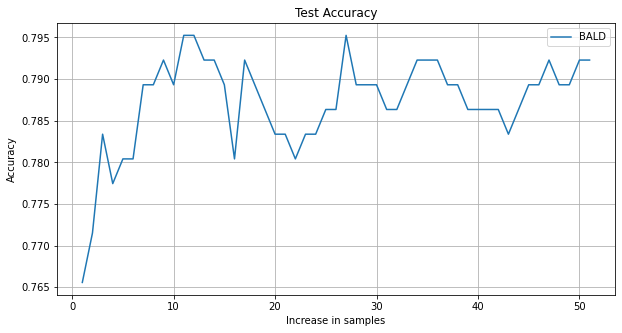

In [9]:
fig = plt.figure(figsize=(10,5))
plt.grid(True, which ="both")
plt.plot(select_count, acc[0:-1])
plt.legend(['BALD'])
plt.title('Test Accuracy')
plt.xlabel('Increase in samples')
plt.ylabel('Accuracy')

# Summary of the Posterior Distribution of the paramaters 
(computed using PYSTAN)

In [20]:
print(fit)

Inference for Stan model: anon_model_16a4048a3c1979a5f7520751e90d6471.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1,1]   2.82    2.24  23.71 -43.12 -12.15   3.17  18.87   49.7    112    1.0
beta[2,1]   2.11    1.22  11.63 -20.96  -6.14    2.6  10.08  26.04     90   1.01
beta[3,1]   3.57    3.69  36.97 -67.09 -22.09    2.3  29.59  74.37    100   1.01
beta[4,1]   4.94    2.69  40.42 -73.66 -23.55   6.52  33.46  85.71    225   1.01
beta[5,1]   2.88    2.45  27.87 -53.37 -14.25   3.26  21.03  55.96    129    1.0
beta[1,2]  -1.16    2.79   26.8 -53.92 -18.44  -0.51  17.19  49.52     92   1.03
beta[2,2]  -0.48    1.32  12.67 -24.57  -9.23  -0.01   8.45  24.45     92   1.04
beta[3,2]   2.29    3.62  37.66  -68.8 -23.44   3.18  25.83   78.3    108   1.03
beta[4,2]   3.03    2.78  38.84 -70.56  -23.8   3.15  30.57   78.5    195    1.0
bet

# Plot of the Posterior Distribution of the paramaters ($\beta$)

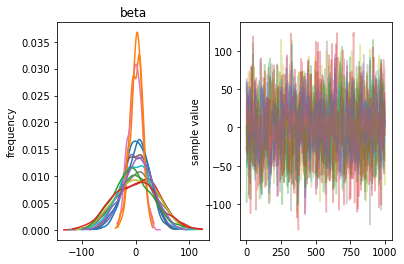

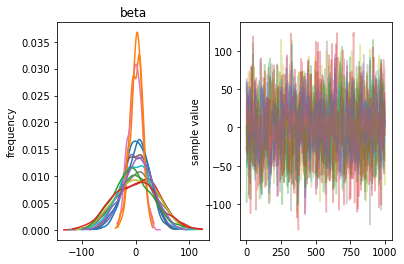

In [21]:
fit.plot()

In [11]:
type(sm)

pystan.model.StanModel